In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
cd /content/drive/My Drive/cvrs

/content/drive/My Drive/cvrs


In [14]:
ls

checkpoint4.h5    low-res                 superResolution_checkpoint3.h5
checkpoint5.h5    metric_results_100.npz  testdata/
data/             metrics_value/          Untitled0.ipynb
img_array.pickle  my_history.npy
LICENSE           README.md


In [3]:
import numpy as np # linear algebra
import pandas as pd 
import os
from PIL import Image
import numpy as np
import re
import glob
import cv2
import tensorflow as tf
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Add, Dropout,Conv2DTranspose
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import pickle


#  Dataset Preperation


1a)After downloading UC Merced Land Use Dataset, I flattened directory structure and all the images in this dataset can be found in /data.

1c)downPixelAggr is a degradation function to obtain downsampled images from the original one, taken from the Sentinel-2 paper repo, 
input_shape=256,256,3
output_shape = 128,128,3

In [4]:
def downPixelAggr(img, SCALE=2):
    from scipy import signal
    import skimage.measure
    from scipy.ndimage.filters import gaussian_filter
    from math import ceil

    if len(img.shape) == 2:
        img = np.expand_dims(img, axis=-1)
    img_blur = np.zeros(img.shape)
    # Filter the image with a Gaussian filter
    for i in range(0, img.shape[2]):
        img_blur[:, :, i] = gaussian_filter(img[:, :, i], 1/SCALE)
    # New image dims
    new_dims = tuple(-(-s//SCALE) for s in img.shape)
    img_lr = np.zeros(new_dims[0:2]+(img.shape[-1],))


    # Iterate through all the image channels with avg pooling (pixel aggregation)
    for i in range(0, img.shape[2]):
        img_lr[:, :, i] = skimage.measure.block_reduce(img_blur[:, :, i], (SCALE, SCALE), np.mean)

    return np.squeeze(img_lr)


If you don't want waste time with preprocessing, don't run the next 3 cell, pass directly to """load pickle""" cell

In [9]:
orig_imgs = glob.glob('data/[!X]*.tif') #returns path of images
print(len(orig_imgs) )

2100


In [10]:
"""read tif images to img_array"""
def read(path):
  img = image.load_img(path)
  img = image.img_to_array(img)
  img = img/255.
  return img

img_array = []
for img in orig_imgs:
    temp=read(img)   
    """some images are not (256,256,3),so they should be eleminated"""
    if temp.shape== (256,256,3):
      img_array.append(temp)

In [11]:
"""creates pickle"""
with open('img_array.pickle','wb') as f:
  pickle.dump(img_array, f)
print(len(img_array))


2056


In [5]:
"""load pickle"""
file = open("img_array.pickle", "rb")
img_array = pickle.load(file)
print(len(img_array))
print(img_array[0].shape)

2056
(256, 256, 3)


1b)creates data splits in training/validation/test (e.g., 70% training, 10% validation, 20% test).

In [6]:
"""all_images_y is the original images , shape= (number of imgs,256,256,3)"""
all_images_y = np.array(img_array)
all_images_x = []
for i in range(all_images_y.shape[0]):
  temp = downPixelAggr(all_images_y[i])
  all_images_x.append(temp)

""" all_images_x is downgraded images  , shape= (number of imgs,128,128,3)"""
all_images_x = np.stack(all_images_x, axis=0) 

print(all_images_x.shape)

#Split test and train data. all_images will be our output images  train=%70 val= %10 test=%20
trainval_y, test_y,trainval_x ,test_x = train_test_split(all_images_y,all_images_x, random_state = 32, test_size=0.2)
train_y, val_y ,train_x,val_x = train_test_split(
    all_images_y,all_images_x, test_size=0.125, random_state=32)

(2056, 128, 128, 3)


# Implementation of the DL-based methods

Because I was experienced with Autoencoder models and liked their broad usage, I preferred to use it as my DL model.I couldn't have chance to experiment AE with another layer structures due to limited time, so I adapted one of the model structure that I've used before to this task.To  overcome the possibility of over-fitting, I used  l1-regularization.

This model takes downgraded images (128,128,3) and try to output images with better resolution in bigger shape(256,256,3)

In [7]:
Input_img = Input(shape=(128, 128, 3))  
    
#encoding architecture
x1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(Input_img)
x2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x1)
x3 = MaxPool2D(padding='same')(x2)
x4 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x3)
x5 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x4)
x6 = MaxPool2D(padding='same')(x5)
encoded = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x6)

# decoding architecture
x7 = Conv2DTranspose(256, kernel_size=(3,3),strides=2,padding='same')(encoded)
x8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x7)
x9 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x8)
x10 = Add()([x5, x9])
x11 = Conv2DTranspose(128, kernel_size=(3,3),strides=2,padding='same')(x10)
x12 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x11)
x13 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x12)
x14 = Add()([x2, x13])


x14b = Conv2DTranspose(64, kernel_size=(3,3),strides=2,padding='same')(x14)
x15 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x14b)
decoded = Conv2D(3, (3, 3), padding='same',activation='relu', kernel_regularizer=regularizers.l1(10e-10))(x15)
autoencoder = Model(Input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [8]:
autoencoder.summary()



Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 18496       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 64)   0           conv2d_1[0][0]                   
_______________________________________________________________________________________

Dif you don't want to train , load the pretrained model and directly pass to the cell sta *results = autoencoder.evaluate(val_x, val_y)*

---



In [9]:
autoencoder.load_weights('checkpoint4.h5')#already trained model weigths 

Checkpoint4 is better but the history plot shows the training between checkpoint 4 and 5

In [10]:
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=50, verbose=1, mode='min')
model_checkpoint =  ModelCheckpoint('checkpoint5.h5', save_best_only = True)

In [11]:
history = autoencoder.fit(train_x,train_y,
            epochs=500,
            validation_data=(val_x, val_y),
            callbacks=[early_stopper, model_checkpoint])


Epoch 1/500
57/57 [==============================] - 30s 523ms/step - loss: 0.0025 - accuracy: 0.7051 - val_loss: 0.0014 - val_accuracy: 0.8248
Epoch 2/500
57/57 [==============================] - 28s 492ms/step - loss: 0.0012 - accuracy: 0.8713 - val_loss: 0.0012 - val_accuracy: 0.8850
Epoch 3/500
57/57 [==============================] - 29s 510ms/step - loss: 0.0011 - accuracy: 0.9007 - val_loss: 0.0012 - val_accuracy: 0.8899
Epoch 4/500
57/57 [==============================] - 30s 525ms/step - loss: 0.0011 - accuracy: 0.9036 - val_loss: 0.0012 - val_accuracy: 0.8980
Epoch 5/500
57/57 [==============================] - 29s 506ms/step - loss: 0.0011 - accuracy: 0.9045 - val_loss: 0.0016 - val_accuracy: 0.8702
Epoch 6/500
57/57 [==============================] - 30s 522ms/step - loss: 0.0012 - accuracy: 0.9018 - val_loss: 0.0012 - val_accuracy: 0.8977
Epoch 7/500
57/57 [==============================] - 30s 523ms/step - loss: 0.0011 - accuracy: 0.9064 - val_loss: 0.0011 - val_accuracy:

Pickle Save History 

In [13]:
np.save('my_history.npy',history.history)


Pickle Load History --if you don't want to train and look up the history of my training

In [ ]:
history=np.load('my_history.npy',allow_pickle='TRUE').item()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


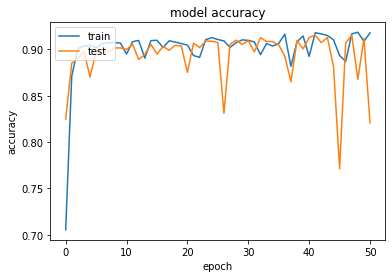

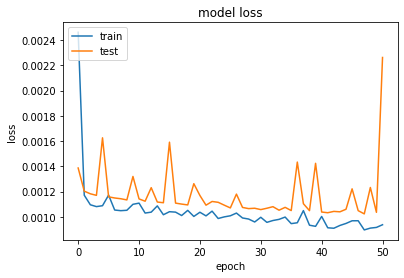

In [15]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

PS: Because the modal started the training with the pretrained weight, train loss quickly decreased in first epochs and the test accuracy didn't show any stable improvement despites its unusual up-downs

In [16]:
results = autoencoder.evaluate(val_x, val_y)
print('val_loss, val_accuracy', results)


9/9 [==============================] - 1s 128ms/step - loss: 0.0023 - accuracy: 0.8206
val_loss, val_accuracy [0.0022613354958593845, 0.8205766677856445]


In [ ]:
predictions = autoencoder.predict(test_x)
n = 4
plt.figure(figsize= (80,40))
for i in range(n):
  ax = plt.subplot(3, n, i+1)
  plt.imshow(test_y[i+20])

  ax = plt.subplot(3, n, i+1+n)
  plt.title("fdfds")
  plt.imshow(predictions[i+20])

plt.show()

Evaluation metric funtions:
taken from : https://github.com/up42/image-similarity-measures/

In [ ]:
import math

import numpy as np
from skimage.metrics import structural_similarity
import phasepack.phasecong as pc
import cv2


def _assert_image_shapes_equal(org_img: np.ndarray, pred_img: np.ndarray, metric: str):
    msg = (f"Cannot calculate {metric}. Input shapes not identical. y_true shape ="
           f"{str(org_img.shape)}, y_pred shape = {str(pred_img.shape)}")

    assert org_img.shape == pred_img.shape, msg


def rmse(org_img: np.ndarray, pred_img: np.ndarray, max_p=4095) -> float:
    """
    Root Mean Squared Error
    Calculated individually for all bands, then averaged
    """
    _assert_image_shapes_equal(org_img, pred_img, "RMSE")

    rmse_bands = []
    for i in range(org_img.shape[2]):
        m = np.mean(np.square((org_img[:, :, i] - pred_img[:, :, i]) / max_p))
        s = np.sqrt(m)
        rmse_bands.append(s)

    return np.mean(rmse_bands)



def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])


def uiq(org_img: np.ndarray, pred_img: np.ndarray, step_size=1, window_size=8):
    """
    Universal Image Quality index
    """
    # TODO: Apply optimization, right now it is very slow
    _assert_image_shapes_equal(org_img, pred_img, "UIQ")
    q_all = []
    for (x, y, window_org), (x, y, window_pred) in zip(sliding_window(org_img, stepSize=step_size,
                                                                      windowSize=(window_size, window_size)),
                                                       sliding_window(pred_img, stepSize=step_size,
                                                                      windowSize=(window_size, window_size))):
        # if the window does not meet our desired window size, ignore it
        if window_org.shape[0] != 8 or window_org.shape[1] != 8:
            continue

        for i in range(org_img.shape[2]):
            org_band = window_org[:, :, i]
            pred_band = window_pred[:, :, i]
            org_band_mean = np.mean(org_band)
            pred_band_mean = np.mean(pred_band)
            org_band_variance = np.var(org_band)
            pred_band_variance = np.var(pred_band)
            org_pred_band_variance = np.mean((org_band - org_band_mean) * (pred_band - pred_band_mean))

            numerator = 4 * org_pred_band_variance * org_band_mean * pred_band_mean
            denominator = (org_band_variance + pred_band_variance) * (org_band_mean**2 + pred_band_mean**2)

            if denominator != 0.0:
                q = numerator / denominator
                q_all.append(q)

    return np.mean(q_all)

def sre(org_img: np.ndarray, pred_img: np.ndarray):
    """
    signal to reconstruction error ratio
    """
    _assert_image_shapes_equal(org_img, pred_img, "SRE")

    sre_final = []
    for i in range(org_img.shape[2]):
        numerator = np.square(np.mean(org_img[:, :, i]))
        denominator = (np.linalg.norm(org_img[:, :, i] - pred_img[:, :, i])) /\
                      (org_img.shape[0] * org_img.shape[1])
        sre_final.append(numerator/denominator)

    return 10 * np.log10(np.mean(sre_final))

In [129]:
def save_testdata_collect_metrics(test_x,test_y,predictions,savedir,save_orig_pred=False):
    if not os.path.exists(savedir):
      os.makedirs(savedir)
    
    rmse_interpol =[]
    rmse_pred=[]
    sre_interpol=[]
    sre_pred=[]
    uiq_interpol=[]
    uiq_pred=[]
    for  i in range(test_x.shape[0]):

              print(i)

              test_yi =(test_y[i] * 255).astype(np.uint8)
              im = Image.fromarray((test_x[i] * 255).astype(np.uint8)) # float32
              im.save(savedir+'/lowrestest_'+str(i)+".tif", "TIFF")

              if save_orig_pred==True:
                im = Image.fromarray(test_yi) # float32
                im.save(savedir+'/origtest_'+str(i)+".tif", "TIFF")

              pred_i=(predictions[i]*255).astype(np.uint8)
              if save_orig_pred==True:
                im = Image.fromarray(pred_i) # float32
                im.save(savedir+'/pred_'+str(i)+".tif", "TIFF")

              img = cv2.imread(savedir+'/lowrestest_'+str(i)+".tif",cv2.IMREAD_COLOR)
              resized = cv2.resize(img,(256,256), interpolation = cv2.INTER_CUBIC)  
              #cv2.imwrite(savedir+'/interpolated_'+str(i)+".tif",resized) 

              rmse_interpol.append(rmse(test_yi,resized))
              rmse_pred.append(rmse(test_yi,pred_i))
              sre_interpol.append(sre(test_yi,resized))
              sre_pred.append(sre(test_yi,pred_i))
              uiq_interpol.append(uiq(test_yi,resized))
              uiq_pred.append(uiq(test_yi,pred_i))

              
              print(rmse_interpol[i])
              print(rmse_pred[i])
              print(sre_interpol[i])
              print(sre_pred[i])
              print(uiq_interpol[i])
              print(uiq_pred[i])




    print(rmse_interpol)
    print(rmse_pred)
    print(sre_interpol)
    print(sre_pred)
    print(uiq_interpol)
    print(uiq_pred)

    return rmse_interpol,rmse_pred ,sre_interpol,sre_pred,uiq_interpol,uiq_pred

        

Running save_testdata_collect_metrics on complete data takes appr. 5 hours, because I was not sure if it would be before deadline, I tried it with first 100 elements of test data

In [130]:
rmse_interpol,rmse_pred ,sre_interpol,sre_pred,uiq_interpol,uiq_pred=save_testdata_collect_metrics(test_x[0:100],test_y[0:100],predictions[0:100],"testdata")

0
0.04075210243935168
0.04013135884787256
39.48647849114502
39.552466530126644
0.6420607186862312
0.7475188012040884
1
0.03625113173153059
0.037580732875795275
47.27785492898191
47.17218247108502
0.6281947691784175
0.5676911622458681
2
0.03998206702306708
0.040962899982721755
43.22298319540015
43.12717435425603
0.597762757846118
0.7115466713847518
3
0.036959272341694514
0.03877238614996034
45.45080718721042
43.938046766036805
0.6193477273277823
0.8160745054471189
4
0.03807711774291264
0.03893539165660842
46.384768895806275
46.092916421363455
0.6846910225584684
0.8402385012359027
5
0.039379623531404805
0.03925025953518602
44.25396428191682
44.04906759564899
0.6849368350873135
0.7853993335260835
6
0.037143924216374684
0.03726604988632518
46.0490644565221
44.93269048307873
0.8609190136245277
0.9363750570274577
7
0.04023208249751322
0.039368017073939034
43.7116620079633
43.82072338814598
0.8278438814663399
0.916415578462972
8
0.039943923110710156
0.036744296243163325
39.886697835451955
40.

In [138]:
from numpy import mean
avg_rmse_interpol=mean(rmse_interpol)
avg_rmse_pred=mean(rmse_pred)
avg_sre_interpol=mean(sre_interpol)
avg_sre_pred=mean(sre_pred)
avg_uiq_interpol=mean(uiq_interpol)
avg_uiq_pred=mean(uiq_pred)




As you can see, on average AE model outperformed the bicubic interpolation
in terms of UIQ whereas the 2 approaches perform at the same level in terms of RMSE and SRE

In [139]:
print("Avg RMSE between original and interpolated: {} ,Avg RMSE between original and output of autoencoder: {} ".format(avg_rmse_interpol,avg_rmse_pred))
print("Avg SRE between original and interpolated: {} ,Avg SRE between original and output of autoencoder: {} ".format(avg_sre_interpol,avg_sre_pred))
print("Avg UIQ between original and interpolated: {} ,Avg UIQ between original and output of autoencoder: {} ".format(avg_uiq_interpol,avg_uiq_pred))

Avg RMSE between original and interpolated: 0.03839359309911734 ,Avg RMSE between original and output of autoencoder: 0.03799425612957516 
Avg SRE between original and interpolated: 44.06774951667006 ,Avg SRE between original and output of autoencoder: 43.61741536461253 
Avg UIQ between original and interpolated: 0.7495237268681081 ,Avg UIQ between original and output of autoencoder: 0.8527669364191879 


In [153]:
np.savez_compressed('metric_results_100.npz', rmse_interpol=rmse_interpol,rmse_pred=rmse_pred,sre_interpol=sre_interpol, sre_pred=sre_pred,uiq_interpol=uiq_interpol,uiq_pred=uiq_pred)


You can load metrics if you don't have much time for running save_testdata_collect_metrics

In [154]:
metrics = np.load('metric_results_100.npz')
print(metrics.files)

['rmse_interpol', 'rmse_pred', 'sre_interpol', 'sre_pred', 'uiq_interpol', 'uiq_pred']


# You can check out the /testdata folder and compare the images in the test set by your eyes

interpolated*.tif     for images after interpolation (256,256,3)

lowrestest*.tif       for downgraded images (input to AE) (128,128,3)

origtest*.tif         for original images (256,256,3)

predtest*.tif         for generated output of AE (256,256,3)


# Potential problems and possible improvements

-Designing autoencoder without ADD layer may give better results, I just picked one of the AE structure that performed well in my old project and adapted it to this task.

-Actually I need to use smaller model because many times I encountered "Run out of RAM" problem during the training.

-GridSearch for hyperparameter optimization would be better( eg. for L1 loss , learn_rate )

-Activation units can be changed to tanh

-Experiment with newly developed optimizers such as AdaBound which combines pros of Adam and SGD